# 1. Logistic regression in PyTorch (25 points)

You are supposed to fill in the missing lines in the notebook `Logistic Regression PyTorch Assignment.ipynb`. The tutorial https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html should provide you with all knowledge you need.

The notebook considers an example where 2D data points are classified using logistic regression and the solution is visualized. First, an implementation in Scikit-Learn is given. Then the same is partly implemented using PyTorch. Your assignment is to fill in the blanks in the PyTorch implementation.

You should add some code in several cells (indicated by "MISSING"). Please write these lines of code in your report, see the LATEX template.

Model      Training Accuracy    Test Accuracy  Weights                      Biases
-------  -------------------  ---------------  ---------------------------  -------------------------------------------------
Sklearn                 0.92             0.84  [[-4.72248492 -0.16581   ]   [ 1.25419104 -2.92928012 -0.65573875  2.33082784]
                                                [-8.30181289  3.88867259]
                                                [ 8.41053572 -3.34398469]
                                                [ 4.6137621  -0.3788779 ]]
PyTorch                 0.92             0.84  [[-5.082279  -0.1432652]     [ 1.4209408  -2.762707   -0.49004444  2.4973857 ]
                                                [-8.661641   3.9112892]
                                                [ 8.050442  -3.3215613]
                                                [ 4.253304  -0.3561876]]


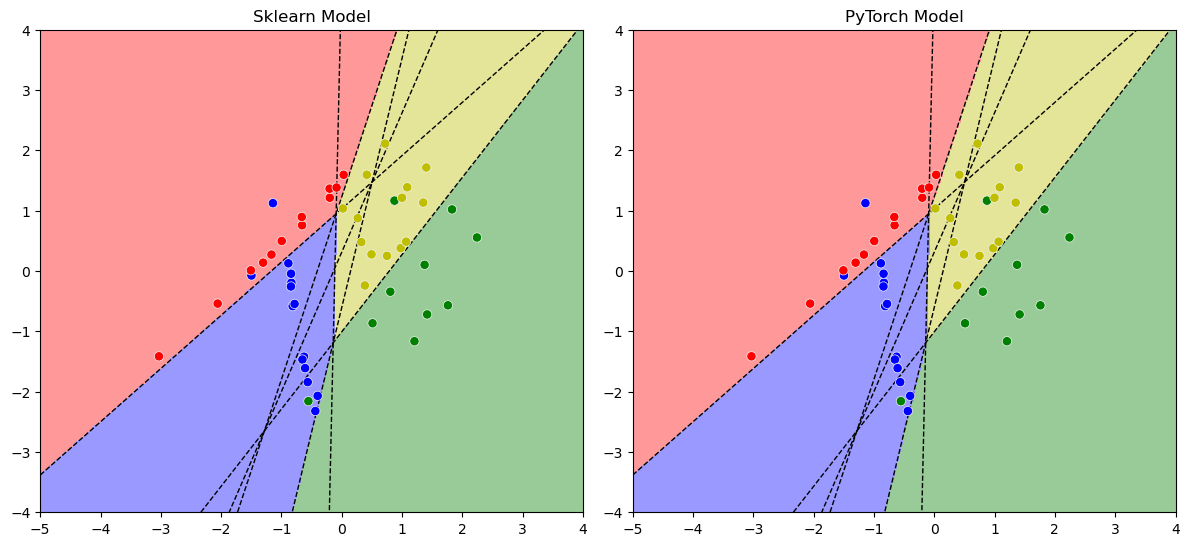

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from tabulate import tabulate

m = 4  # Number of classes
d = 2  # In-out dimensionality
train_n = 50  # Training set size
test_n = 25  # Test set size
colors = ['b', 'r', 'g', 'y'] # Colors for the classes

# Data Generation
def generate_data():
    X, y = make_classification(n_samples=test_n + train_n,
                               n_features=d,
                               n_informative=d,
                               n_redundant=0,
                               n_repeated=0,
                               n_classes=m,
                               n_clusters_per_class=1,
                               weights=None,
                               flip_y=0.01,
                               class_sep=0.75,
                               hypercube=True,
                               shift=0.0,
                               scale=1.0,
                               shuffle=True,
                               random_state=None)
    return train_test_split(X, y, test_size=test_n, random_state=4711)

# Model Definitions
class LogisticRegressionPytorch(nn.Module):
    def __init__(self, d, m):
        super(LogisticRegressionPytorch, self).__init__()
        self.fc = nn.Linear(d, m) # HC: Linear layer with d inputs and m outputs

    def forward(self, x):
        return F.log_softmax(self.fc(x), dim=1) # HC: Softmax activation function

# Training Functions
def train_sklearn(X_train, y_train):
    logreg = LogisticRegression(penalty=None,
                                fit_intercept=True,
                                multi_class='multinomial',
                                solver='lbfgs')
    logreg.fit(X_train, y_train)
    return logreg

def train_pytorch(X_train, y_train):
    logreg_pytorch = LogisticRegressionPytorch(d, m)
    optimizer = optim.Adam(logreg_pytorch.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss() # HC: Cross entropy loss function
    X_train_T = torch.Tensor(X_train) # Automatically casts to foat
    y_train_T = torch.from_numpy(y_train).long() # Does not cast to float
    for _ in range(10000): # Loop over the dataset multiple times
        optimizer.zero_grad() # Zero the parameter gradients
        outputs = logreg_pytorch(X_train_T) # Forward + backward + optimize
        loss = criterion(outputs, y_train_T) # HC: Compute the loss
        loss.backward() # HC: Backpropagation
        optimizer.step()
    return logreg_pytorch

# Plotting
def plot_decision_boundary(X, y, model, ax, title, torch_model=False, add_colorbar=False):
    # Colors for the classes
    colors = ['b', 'r', 'g', 'y']
    class_colours = [colors[i] for i in y]
    cmap = plt.matplotlib.colors.ListedColormap(colors[:len(np.unique(y))])

    # Compute the plot boundaries
    xl, xh = np.floor(X[:, 0].min() - 1), np.ceil(X[:, 0].max() + 1)
    yl, yh = np.floor(X[:, 1].min() - 1), np.ceil(X[:, 1].max() + 1)

    # Create grid to calculate the decision boundary
    res = (xh - xl) / 300  # Resolution of the grid
    xx, yy = np.meshgrid(np.arange(xl, xh, res), np.arange(yl, yh, res))

    # Classify each point on the grid
    if torch_model:
        with torch.no_grad():  # Disable gradient tracking
            outputs = model(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]))
        _, predicted = torch.max(outputs.data, 1)
        Z = predicted.numpy().reshape(xx.shape)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

    # Plot points in their respective color classes
    ax.scatter(X[:, 0], X[:, 1], s=45, c=class_colours, edgecolor=plt.cm.gray(.95), lw=0.5, zorder=100)

    # Plot decision boundaries with dashed lines
    for i in np.arange(m - 1):
        for j in np.arange(i + 1, m):
            if torch_model:
                with torch.no_grad():  # Disable gradient tracking
                    w = model.fc.weight[i] - model.fc.weight[j]
                    b = model.fc.bias[i] - model.fc.bias[j]
                    b = -b / w[1]
                    a = -w[0] / w[1]
                    x_line = np.arange(xl, xh, res)
                    y_line = a * x_line + b
                    ax.plot(x_line, y_line, "k", lw=1, ls='--')
            else:
                w = model.coef_[i] - model.coef_[j]
                b = model.intercept_[i] - model.intercept_[j]
                b = -b / w[1]
                a = -w[0] / w[1]
                x_line = np.arange(xl, xh, res)
                y_line = a * x_line + b
                ax.plot(x_line, y_line, "k", lw=1, ls='--')
    
    ax.set_xlim(xl, xh)
    ax.set_ylim(yl, yh)

    ax.matshow(Z, cmap=cmap, origin="lower", extent=[xl, xh, yl, yh], aspect="auto", alpha=.4)
    
    ax.xaxis.tick_bottom()
    ax.set_aspect('equal')
    ax.set_title(title)

def pytorch_accuracy(model, X, y_true):
    with torch.no_grad():
        outputs = model(torch.Tensor(X))
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == torch.Tensor(y_true).long()).sum().item()
    return correct / len(y_true)

# Main Execution
X_train, X_test, y_train, y_test = generate_data()

# Train sklearn model
logreg = train_sklearn(X_train, y_train)
ws_sklearn = logreg.coef_
bs_sklearn = logreg.intercept_

# Train PyTorch model
logreg_pytorch = train_pytorch(X_train, y_train)
ws_torch = logreg_pytorch.fc.weight.detach().numpy() # HC: Get the weights of the linear layer
bs_torch = logreg_pytorch.fc.bias.detach().numpy() # HC: Get the biases of the linear layer

table = [
    ["Model", "Training Accuracy", "Test Accuracy", 'Weights', 'Biases'],
    ["Sklearn", logreg.score(X_train, y_train), logreg.score(X_test, y_test), ws_sklearn, bs_sklearn],
    ["PyTorch", pytorch_accuracy(logreg_pytorch, X_train, y_train), pytorch_accuracy(logreg_pytorch, X_test, y_test), ws_torch, bs_torch]
]
print(tabulate(table, headers='firstrow'))

# Plot decision boundaries side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plot_decision_boundary(X_train, y_train, logreg, ax1, 'Sklearn Model', add_colorbar=True)
plot_decision_boundary(X_train, y_train, logreg_pytorch, ax2, 'PyTorch Model', torch_model=True)
plt.tight_layout()
plt.show()

# 2. Convolutional Neural Networks

## 2.1. Sobel filter (25 points)

In this assignment, you should implement a Sobel filter in PyTorch. The learning goals are a better understanding of basic image filtering operations, a deep understanding of how the PyTorch convolutional layers work, and better PyTorch programming skills.

The Sobel filter is a basic operator to highlight edges in images (e.g., see Wikipedia). It convolves the image with two 3×3 filters, the results of which are combined. Let the matrix I represent a (single-channel) 2D input image and ∗ the convolution operator. Then the Sobel filter computes in a first step
$$
\mathbf{G}_x =
    \begin{bmatrix}
        1 & 0 & -1 \\
        2 & 0 & -2 \\
        1 & 0 & -1
    \end{bmatrix} \ast \mathbf{I}
    
    \quad \text{and} \quad
    
    \mathbf{G}_y =
    \begin{bmatrix}
        1 & 2 & 1 \\
        0 & 0 & 0 \\
        -1 & -2 & -1
    \end{bmatrix} \ast \mathbf{I},
\tag{1}
$$

which are then combined to a feature map
$$
[\mathbf{G}]_{ij} = \sqrt{[\mathbf{G}_x]_{ij}^2 + [\mathbf{G}_y]_{ij}^2}
\tag{2}
$$
where $[\cdot]_{ij}$ denotes the matrix element at position $ij$. Start by going through the notebook `PyTorch 2D convolutions.ipynb`, which gives some examples on how to work with 2D convolutions in PyTorch and provides some basics on how to read and display images. Do this carefully. First, it is surprising how many people doing deep learning in Python actually do not know what is going in a simple convolutional layer. Second, handling input images in real-world applications can sometimes be tricky (and I am not claiming that the way I did it in the notebook is the most elegant one).

Implement the Sobel filter. Use a single `nn.Conv2d` call to generate the two feature maps $\mathbf{G}_x$ and $\mathbf{G}_y$. For squaring each element in a filter output you can use something like `torch.square`. For combining filter outputs as in (2) you can use `torch.sum`, but you have to set the axis argument properly.

Deliverables: Show the important parts of your code (i.e., the Sobel filter) in the report. Apply the Sobel filter to the same input image as in `PyTorch 2D convolutions.ipynb`. Deliverables: Show plots of the two feature maps and the final result (i.e., $\mathbf{G}_x$, $\mathbf{G}_y$, and $\mathbf{G}$).

Deliverables: In the report, discuss how you considered the difference between convolution and cross-correlation (note that the latter is what the "convolutional" layer is doing) in your implementation.

### Sobel Filter Implementation

In [ ]:
import torch
import torch.nn as nn

class SobelFilter(nn.Module):
    def __init__(self):
        super(SobelFilter, self).__init__()
        # Define the Sobel filter kernels
        self.sobel_kernel_x = torch.tensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).float().unsqueeze(0).unsqueeze(0)
        self.sobel_kernel_y = torch.tensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]).float().unsqueeze(0).unsqueeze(0)
        
        # Combine the kernels into a single tensor
        self.sobel_kernels = torch.cat([self.sobel_kernel_x, self.sobel_kernel_y], dim=0)
        
        # Create a convolutional layer with the Sobel filters
        self.conv = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, padding=1, bias=False)
        self.conv.weight.data = self.sobel_kernels

    def forward(self, x):
        # Apply the Sobel filters
        Gx, Gy = torch.split(self.conv(x), 1, dim=1)
        
        # Compute the magnitude of the gradient
        G = torch.sqrt(torch.square(Gx) + torch.square(Gy))
        
        return Gx, Gy, G

### Load the image

In [ ]:
# Convolution filter with size W
W = 3

# Input (image) `x`.
# The input image is a square with a single channel.
x = torch.arange(float(W*W))
x = torch.reshape(x, (1, 1, W, W))
print('Input image:\n', x)

Input image:
 tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])


### Applying the Sobel Filter

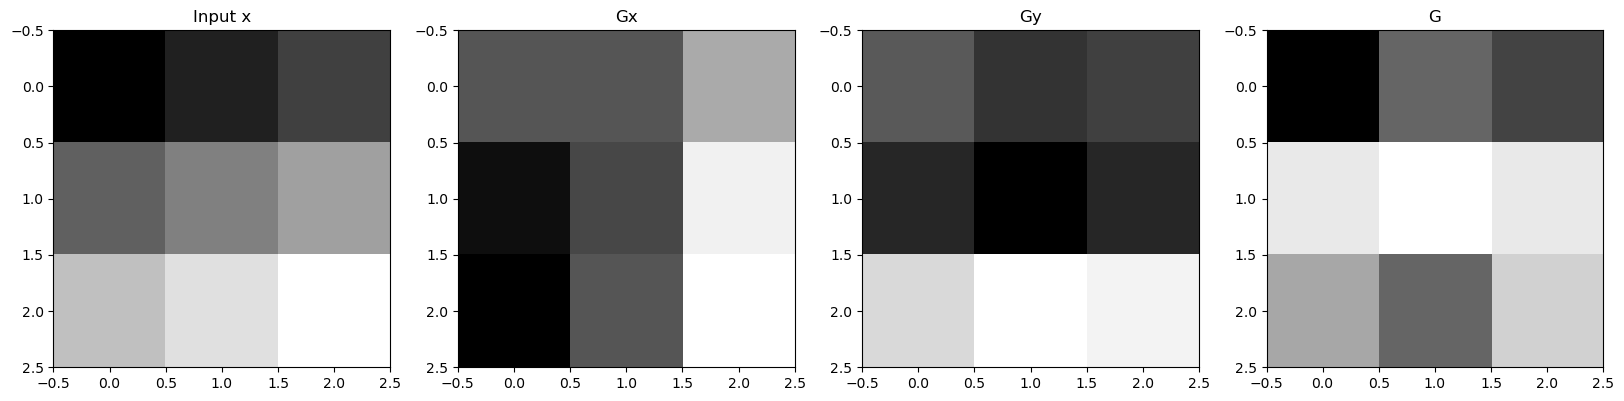

In [ ]:
sobel_filter = SobelFilter()
Gx, Gy, G = sobel_filter(x)

# Display the results
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# Display the input image x
plt.subplot(1, 4, 1)
plt.imshow(x[0, 0].detach().numpy(), cmap='gray')
plt.title('Input x')

# Display Gx
plt.subplot(1, 4, 2)
plt.imshow(Gx[0, 0].detach().numpy(), cmap='gray')
plt.title('Gx')

# Display Gy
plt.subplot(1, 4, 3)
plt.imshow(Gy[0, 0].detach().numpy(), cmap='gray')
plt.title('Gy')

# Display G
plt.subplot(1, 4, 4)
plt.imshow(G[0, 0].detach().numpy(), cmap='gray')
plt.title('G')

plt.show()

### Discussion on Convolution vs. Cross-Correlation
In the context of neural networks, the operation performed by the "convolutional" layer is technically cross-correlation, not convolution. The difference lies in the way the kernel is applied to the input. In convolution, the kernel is flipped both horizontally and vertically before sliding over the input, while in cross-correlation, it is not flipped.

For the Sobel filter, this distinction is crucial. If you were to use the exact Sobel kernels in a convolution operation, you would get incorrect results. However, since PyTorch's nn.Conv2d performs cross-correlation, the Sobel kernels work as expected without any modifications.

In summary, when implementing filters like the Sobel filter in deep learning frameworks, it's essential to be aware of the operation being performed (cross-correlation) and ensure that filter kernels are defined accordingly.

## 2.2. Convolutional neural networks (25 points)

The learning goal of this part of the assignment is to get more comfortable with implementing convolutional neural networks (CNNs) in PyTorch.

Consider the notebook `Torch_Traffic_Signs_Basic_Template.ipynb` and the file `GTSRBTrafficSigns.py`. The notebook is a template for training a convolutional neural network (CNN) for classifying traffic signs on the same data as the competition described by Stallkamp et al. (2012). The data is handled by the Dataset class in the file `GTSRBTrafficSigns.py`. Recognition of traffic signs is a challenging real-world problem of high industrial relevance. Traffic sign recognition can be viewed as a multi-class classification problem with unbalanced class frequencies, in which one has to cope with large variations in visual appearances due to illumination changes, partial occlusions, rotations, weather conditions, etc. However, humans are capable of recognizing the large variety of existing road signs with close to 100% correctness – not only in real-world driving situations, which provides both context and multiple views of a single traffic sign, but also when looking at single images as those shown in Figure 1. Now the question is how good a computer can become at solving this problem.

The notebook is supposed to run with GPU support, for example, using _Google Colaboratory_. Even then, executing it will take some time.

The notebook misses the CNN definition. Define a network with a
- convolutional layer creating 64 feature maps using 5×5 kernels followed by a
- 2 × 2 max-pooling layer followed by a
- convolutional layer creating 64 feature maps using 5×5 kernels followed by a
- 2 × 2 max-pooling layer followed by a
- linear fully-connected layer with 43 outputs.

After each convolutional layer, the ELU (exponential linear unit, Clevert et al. (2016)) activation function should be applied.

Deliverables: Show the model definition in the report.
You should get the following output when you print your model:
``````
    Net(
        ( conv1 ): Conv2d (3, 64, kernel_size =(5, 5) , stride =(1, 1))
        ( pool1 ): MaxPool2d ( kernel_size =2, stride =2, padding =0, dilation
        =1, ceil_mode = False )
        ( conv2 ): Conv2d (64 , 64, kernel_size =(5, 5) , stride =(1, 1))
        ( pool2 ): MaxPool2d ( kernel_size =2, stride =2, padding =0, dilation
        =1, ceil_mode = False )
        (fc2): Linear ( in_features =1024 , out_features =43, bias = True )
    )
``````

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from tabulate import tabulate
from GTSRBTrafficSigns import GTSRBTrafficSigns
from tqdm import tqdm

# Initialize device and check for GPU
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

def load_data(batch_size=128):
    dataset_train = GTSRBTrafficSigns()
    generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
    print("Number of training patterns:", len(dataset_train))
    return dataset_train, generator_train

def imshow(img, figsize=(2, 2)):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_sample_images(generator_train):
    dataiter = iter(generator_train)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    for i in range(batch_size):
        imshow(images[i])
        print(labels[i].item(), "\n\n")

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc_input_size = 1024
        self.fc2 = nn.Linear(self.fc_input_size, 43)

    def forward(self, x):
        x = self.pool1(F.elu(self.conv1(x)))
        x = self.pool2(F.elu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = self.fc2(x)
        return x

def train_model(net, generator_train, no_epochs=200):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)
    loss_history = []

    for epoch in enumerate(tqdm(range(no_epochs), desc='Epochs', unit='epoch')):
        running_loss = 0.0
        
        # Inner progress bar for batches within an epoch
        for i, data in enumerate(generator_train):
            inputs, labels = data[0].to(device) if gpu else data[0], data[1].to(device) if gpu else data[1]
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            reporting_interval = 100
            if i % reporting_interval == reporting_interval - 1:
                loss_avg = running_loss / reporting_interval
                loss_history.append(loss_avg)
                running_loss = 0.0

    plt.plot(loss_history)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.show()

def test_model(net, dataset_test, batch_size):
    generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
    print("Number of test patterns:", len(dataset_test))
    correct = 0
    total = 0
    with torch.no_grad():
        for data in generator_test:
            images, labels = data[0].to(device) if gpu else data[0], data[1].to(device) if gpu else data[1]
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(tabulate([['Accuracy', f'{accuracy:.2f} %']], headers=['Metric', 'Value']))

if __name__ == '__main__':
    batch_size = 128
    dataset_train, generator_train = load_data(batch_size)
    #show_sample_images(generator_train)

    net = Net().to(device)
    print(net)

    cont = False
    if cont:
        net.load_state_dict(torch.load('traffic_simple'))

    train_model(net, generator_train)

    dataset_test = GTSRBTrafficSigns(train=False)
    test_model(net, dataset_test, batch_size)
    
    torch.save(net.state_dict(), 'traffic_simple')


device: cpu
Using existing ./GTSRB/train
Number of training patterns: 39209
Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)


Epochs:   0%|          | 0/200 [00:00<?, ?epoch/s]

## 2.3. Augmentation (25 points)

Convolutional neural networks are highly complex models. To reduce the risk of overfitting and to be able to learn difficult tasks with a high input variability, many training examples are needed. Data augmentation is a way to enlarge the training data set by artificial training points generated from the available data. Data augmentation refers to applying transformations to the input data (the images) that do not change their labels. If we know, for example, that the classifications of images do not change when the images are rotated, then showing rotated versions of the images during the training process helps to learn this invariance property. In the context of neural networks, this type of data augmentation can be traced back to Baird (1992). It has been used successfully for CNNs, for instance, already in the influential work by Krizhevsky et al. (2012).

The learning goal of this part of the assignment is to get more experience in using data augmentation.

Inspect the notebook `Torch_Traffic_Signs_Basic_Template.ipynb`.

Deliverables: Answer the following questions briefly in your report: Which transformations are applied to the input images during training? Why is a transformation conditioned on the label?

Please add at least one additional (not completely nonsensical) transformation.

Deliverables: Show the corresponding code in your report and briefly argue why you think that this may be a reasonable augmentation given the task.

### Answering the Questions

1. **Which transformations are applied to the input images during training?**
   - `transforms.Resize((self.img_width,self.img_height))`: Resizes the image to the specified width and height.
   - `transforms.RandomAffine((-5,5))`: Applies a random affine transformation to the image with rotation angles between -5 and 5 degrees.
   - `transforms.RandomCrop((self.img_width_crop, self.img_height_crop))`: Randomly crops the image to the specified width and height.
   - `transforms.ColorJitter(0.8, contrast = 0.4)`: Randomly changes the brightness by 0.8 and contrast by 0.4 of the image.
   - Conditionally, if the label of the image is in `[11, 12, 13, 17, 18, 26, 30, 35]`, a `transforms.RandomHorizontalFlip(p=0.5)` is applied, which flips the image horizontally with a probability of 0.5.

2. **Why is a transformation conditioned on the label?**
   - The conditional transformation `transforms.RandomHorizontalFlip(p=0.5)` is applied only to images with specific labels. This suggests that for these particular traffic signs, a horizontal flip does not change their meaning or interpretation. For example, a "No Entry" sign would still mean "No Entry" even if flipped horizontally. However, for other signs, a horizontal flip might change their meaning, so it's crucial to condition this transformation on the label to ensure the augmented data still correctly represents the original label.

3. **Please add at least one additional (not completely nonsensical) transformation.**
   - A potential transformation to consider is `transforms.RandomVerticalFlip(p=0.5)`. However, this might not be suitable for all traffic signs as it could change their meaning. Another option could be `transforms.RandomRotation(degrees=10)`, which rotates the image by a random angle between -10 and 10 degrees. This can simulate the real-world scenario where traffic signs might not always be perfectly upright due to wear and tear or other factors.

Here's the modified code with the added transformation:

```python
def __getitem__(self, index):
    image, label = self.dataset_train.__getitem__(index)
    image = transforms.Resize((self.img_width,self.img_height))(image)
    
    if self.train:
        image = transforms.RandomAffine((-5,5))(image)
        image = transforms.RandomCrop((self.img_width_crop, self.img_height_crop))(image)
        image = transforms.ColorJitter(0.8, contrast = 0.4)(image)
        image = transforms.RandomRotation(degrees=10)(image)  # Added transformation
        if label in [11, 12, 13, 17, 18, 26, 30, 35]:
            image = transforms.RandomHorizontalFlip(p=0.5)(image)
    else:
        image = transforms.CenterCrop((self.img_width_crop, self.img_height_crop))(image)

    image = transforms.ToTensor()(image)

    return image, label
```

**Reasoning for the added transformation:**
Rotating the image by a small angle can be a reasonable augmentation for traffic signs. In real-world scenarios, traffic signs might not always be perfectly upright due to various reasons like wind, accidental hits, or installation angles. By introducing this slight rotation during training, the model can become more robust to such variations in the test data.